## Examples of NeuralUQ, for uncertainty quantification in scientific machine learning
#### 1. [Function regression from data using Bayesian neural networks](#Function-regression-from-data-using-Bayesian-neural-networks)
#### 2. [Solving 1-D Poisson equation from data of source term (the forward problem), using Bayesian PINNs](#Solving-1-D-Poisson-equation-from-data-of-source-term-(the-forward-problem),-using-Bayesian-PINNs)
#### 3. [Inferring a parameter and the solution of a 1-D Poisson equation from data of source term and the solution (the inverse problem), using Bayesian PINNs](#Inferring-a-parameter-and-the-solution-of-a-1-D-Poisson-equation-from-data-of-source-term-and-the-solution-(the-inverse-problem),-using-Bayesian-PINNs)
#### 4. [Few-shot function regression from data, using learned generators](#Few-shot-function-regression-from-data,-using-learned-generators)
#### 5. [Inferring parameters of four-fiber family model, from data of stress](#Inferring-parameters-of-four-fiber-family-model,-from-data-of-stress)


# Function regression from data using Bayesian neural networks

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time
import neuraluq0.neuraluq as neuq
import tensorflow as tf
#from neuq.backend import backend_name, tf, jax, tfp

Backend is chosen to be the default, tensorflow. You can customize the backend by change it in the 'config.json' file, which can be created or found in your current directory.


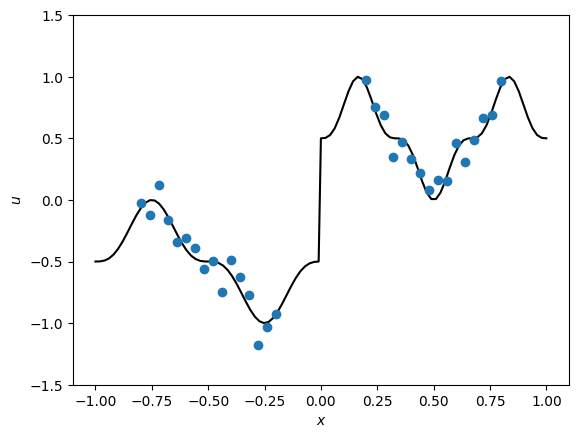

In [7]:
def load_data():
    data = sio.loadmat("./dataset/func_train.mat")
    x_u_train = data["x_train"]
    u_train = data["y_train"]
    x_test = data["x_test"]
    u_test = data["y_test"]
    return x_u_train, u_train, x_test, u_test

# load data
x_train, u_train, x_test, u_test = load_data()
plt.plot(x_test, u_test, "k-")
plt.plot(x_train, u_train, "o")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.ylim([-1.5, 1.5])
plt.show()

#### Build a process of $u$

In [8]:
layers = [1, 50, 50, 1]
# a fully-connected NN
surrogate = neuq.surrogates.FNN(layers=layers)
# independent Gaussian prior for all weights and biases
prior = neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1)
# combine them and make a process
process_u = neuq.Process(surrogate=surrogate, prior=prior)

#### Build a likelihood, for the measurements of $u$

In [9]:
likelihood = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=u_train,
    processes=[process_u],
    sigma=0.1,
)#### Build a model out of a posterior distribution

#### Build a model out of a posterior distribution

In [10]:
model = neuq.Model(processes=[process_u], likelihoods=[likelihood])

Supporting backend tensorflow



#### Choose a method, and run it

In [11]:
# adaptive HMC
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [12]:
t0 = time.time()
samples, results = model.run()
print("Acceptance rate: %.3f \n" % (np.mean(results)))  # if HMC is used
print("Elapsed ", time.time() - t0)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.599 

Elapsed  21.531633138656616


#### From samples of parameters to samples of functions

In [13]:
u_samples = model.predict(
    inputs=x_test,
    samples=samples,
    processes=[process_u],
)[0]
mu = np.mean(u_samples, axis=0)
std = np.std(u_samples, axis=0)

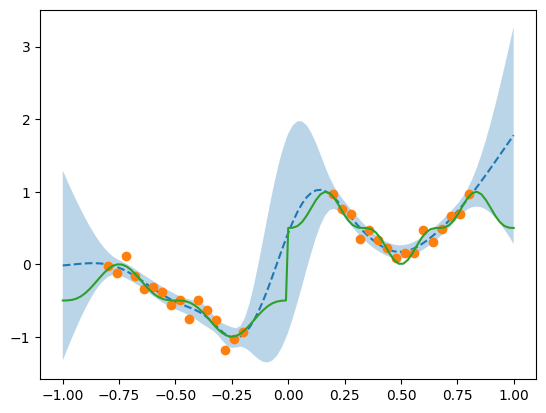

In [14]:
plt.plot(x_test, mu, "--")
plt.plot(x_train, u_train, "o")
plt.fill_between(
    x_test.flatten(), (mu + 2 * std).flatten(), (mu - 2 * std).flatten(), alpha=0.3
)
plt.plot(x_test, u_test)
plt.show()

# Solving 1-D Poisson equation from data of source term (the forward problem), using Bayesian PINNs

$$D u_{xx} + k \tanh(u) = f, x\in[-0.7, 0.7],\\D =0.01, k=0.7.$$

Reference: B-PINNs paper.

In [15]:
def load_data():
    data = sio.loadmat("./dataset/Poisson_forward.mat")
    x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
    x_u_train, u_train = data["x_u_train"], data["u_train"]
    x_f_train, f_train = data["x_f_train"], data["f_train"]
    return x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test


def pde_fn(x, u_fn):
    # for backend Tensorflow, using tf.GradientTape() to compute gradients,
    # compatible with both graph/tf.function and eager modes
    D, k = 0.01, 0.7
    with tf.GradientTape() as g_xx:
        g_xx.watch(x)
        with tf.GradientTape() as g_x:
            g_x.watch(x)
            u = u_fn(x)
        u_x = g_x.gradient(u, x)
    u_xx = g_xx.gradient(u_x, x)
    return D * u_xx + k * tf.tanh(u)


# def pde_fn(x, u_fn):
#     # for backend Tensorflow, using tf.gradients to compute gradients,
#     # compatible with graph/tf.function mode
#     D, k = 0.01, 0.7
#     u = u_fn(x)
#     u_x = tf.gradients(u, x)[0]
#     u_xx = tf.gradients(u_x, x)[0]
#     return D * u_xx + k * tf.tanh(u)


# def pde_fn(x, u_fn):
#     # for backend Tensorflow, using tf.GradientTape() to compute gradients,
#     # compatible with both graph/tf.function and eager modes
#     D, k = 0.01, 0.7

#     def u_x_fn(x):
#         u, vjp_fn = jax.vjp(u_fn, x, has_aux=False)
#         return vjp_fn(jax.numpy.ones_like(x))[0], u

#     u_x, vjp_fn, u = jax.vjp(u_x_fn, x, has_aux=True)
#     u_xx = vjp_fn(jax.numpy.ones_like(x))[0]
#     # u = u_fn(x)
#     return D * u_xx + k * jax.numpy.tanh(u)

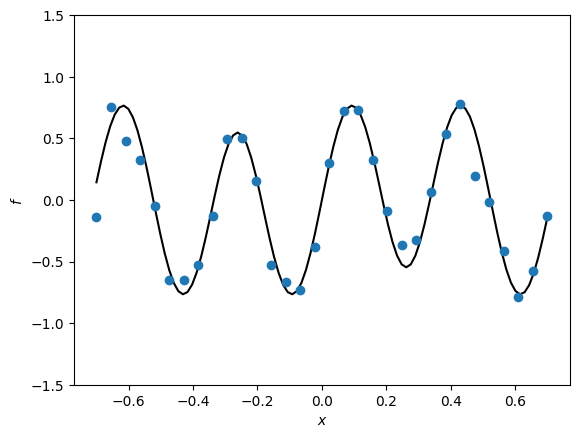

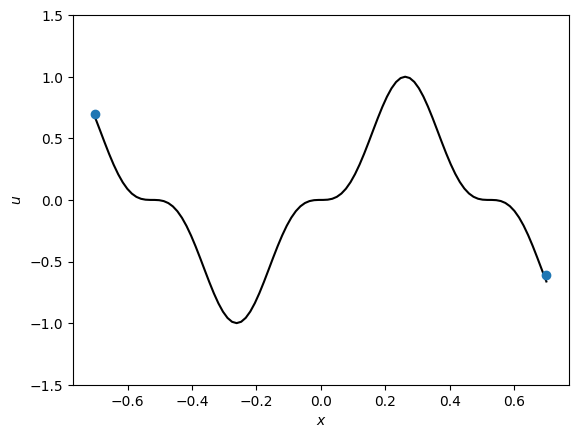

In [16]:
# load data
x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test = load_data()

plt.plot(x_test, f_test, "k-")
plt.plot(x_f_train, f_train, "o")
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.ylim([-1.5, 1.5])
plt.show()

plt.plot(x_test, u_test, "k-")
plt.plot(x_u_train, u_train, "o")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.ylim([-1.5, 1.5])
plt.show()

#### Build a process of $u$

In [21]:
layers = [1, 50, 50, 1]
process_u = neuq.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)

#### Build likelihoods of $u$ and $f$, because we have measurements of both.

In [22]:
likelihood_u = neuq.likelihoods.Normal(
    inputs=x_u_train,
    targets=u_train,
    processes=[process_u],
    sigma=0.05,
)
likelihood_f = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process_u],
    equation=pde_fn,
    sigma=0.1,
)

#### Build a model out of a posterior distribution

In [23]:
model = neuq.Model(
    processes=[process_u], 
    likelihoods=[likelihood_u, likelihood_f],
)

Supporting backend tensorflow



#### Choose a method and run it

In [24]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=3434,
)
model.compile(method)
t0 = time.time()
samples, results = model.run()
print("Acceptance rate: %.3f \n" % (np.mean(results)))  # if HMC is used
#print("Elapsed: ", time.time() - t0, " with backend {}".format(backend_name))

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.451 



NameError: name 'backend_name' is not defined

#### From samples of parameters to samples of functions

In [25]:
u_samples = model.predict(
    x_test, 
    samples, 
    processes=[process_u],
)[0]
f_samples = model.predict(
    x_test, 
    samples, 
    processes=[process_u], 
    equation=pde_fn,
)[0]

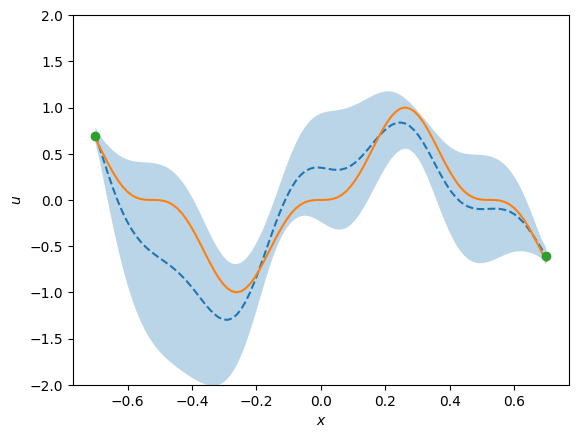

In [26]:
mu = np.mean(u_samples, axis=0)
std = np.std(u_samples, axis=0)
plt.fill_between(
    x_test.flatten(), (mu + 2.0 * std).flatten(), (mu - 2.0 * std).flatten(), alpha=0.3
)
plt.plot(x_test, mu, "--")
plt.plot(x_test, u_test)
plt.plot(x_u_train, u_train, "o")
plt.ylim([-2, 2])
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.show()

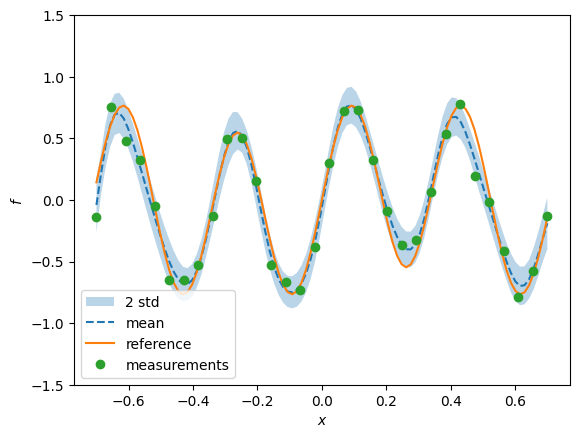

In [132]:
mu = np.mean(f_samples, axis=0)
std = np.std(f_samples, axis=0)
plt.fill_between(
    x_test.flatten(),
    (mu + 2 * std).flatten(),
    (mu - 2 * std).flatten(),
    alpha=0.3,
    label="2 std",
)
plt.plot(x_test, mu, "--", label="mean")
plt.plot(x_test, f_test, label="reference")
plt.plot(x_f_train, f_train, "o", label="measurements")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.ylim([-1.5, 1.5])
plt.show()

# Inferring a parameter and the solution of a 1-D Poisson equation from data of source term and the solution (the inverse problem), using Bayesian PINNs

$$D u_{xx} + k \tanh(u) = f, x\in[-0.7, 0.7],\\D=0.01, k\text{ unknown}.$$

Reference: B-PINNs paper.

In [27]:
def load_data():
    data = sio.loadmat("./dataset/Poisson_inverse.mat")
    x_test, u_test, f_test = data["x_test"], data["u_test"], data["f_test"]
    x_u_train, u_train = data["x_u_train"], data["u_train"]
    x_f_train, f_train = data["x_f_train"], data["f_train"]
    return x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test


def pde_fn(x, u_fn, k_fn):
    # for backend Tensorflow, using tf.GradientTape() to compute gradients,
    # compatible with both graph/tf.function and eager modes
    D = 0.01
    with tf.GradientTape() as g_xx:
        g_xx.watch(x)
        with tf.GradientTape() as g_x:
            g_x.watch(x)
            u = u_fn(x)
        u_x = g_x.gradient(u, x)
    u_xx = g_xx.gradient(u_x, x)
    k = tf.math.exp(k_fn(x))
    return D * u_xx + k * tf.tanh(u)

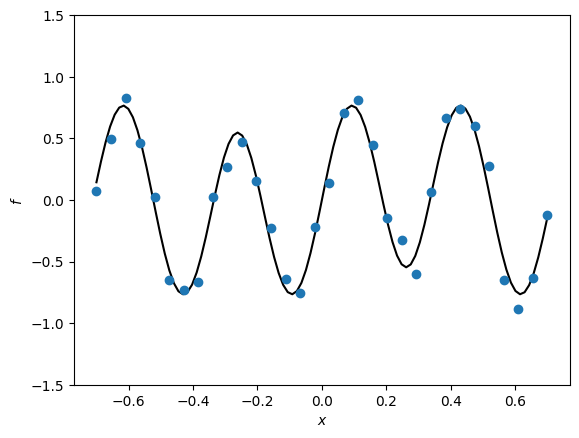

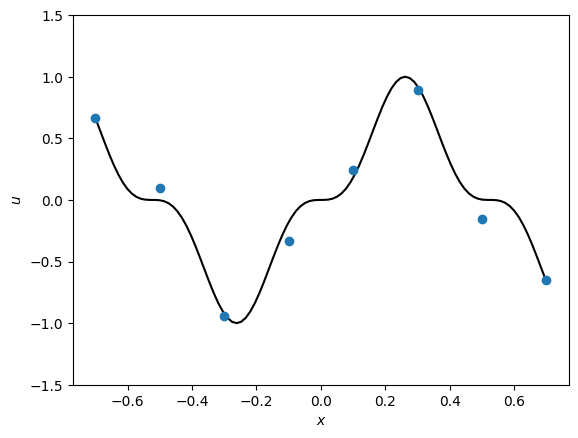

In [28]:
# load data
x_u_train, u_train, x_f_train, f_train, x_test, u_test, f_test = load_data()

plt.plot(x_test, f_test, "k-")
plt.plot(x_f_train, f_train, "o")
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.ylim([-1.5, 1.5])
plt.show()

plt.plot(x_test, u_test, "k-")
plt.plot(x_u_train, u_train, "o")
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.ylim([-1.5, 1.5])
plt.show()

#### Build a process of $u$ and $k$

In [29]:
layers = [1, 50, 50, 1]
process_u = neuq.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)
process_log_k = neuq.Process(
    surrogate=neuq.surrogates.Identity(),
    prior=neuq.variables.const.Samplable(mean=0, sigma=1), # log_k \sim N(0, 1)
)

#### Build likelihoods of $u$ and $f$

In [30]:
likelihood_u = neuq.likelihoods.Normal(
    inputs=x_u_train,
    targets=u_train,
    processes=[process_u],
    sigma=0.1,
)
likelihood_f = neuq.likelihoods.Normal(
    inputs=x_f_train,
    targets=f_train,
    processes=[process_u, process_log_k],
    equation=pde_fn,
    sigma=0.1,
)

#### Build a model, choose a method, and run it

In [31]:
model = neuq.Model(
    processes=[process_u, process_log_k], 
    likelihoods=[likelihood_u, likelihood_f],
)

method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)
t0 = time.time()
samples, results = model.run()
print("Acceptance rate: %.3f \n" % (np.mean(results)))  # if HMC is used
#print("Elapsed: ", time.time() - t0, " with backend {}".format(backend_name))

Supporting backend tensorflow

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.619 



#### From samples of parameters to samples of functions

In [32]:
u_samples = model.predict(
    x_test, 
    samples, 
    processes=[process_u],
)[0]
f_samples = model.predict(
    x_test, 
    samples, 
    processes=[process_u, process_log_k], 
    equation=pde_fn,
)[0]
log_k_samples = samples[-1]

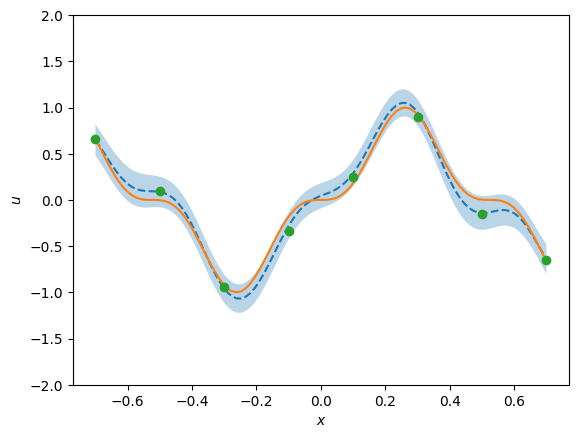

In [33]:
mu = np.mean(u_samples, axis=0)
std = np.std(u_samples, axis=0)
plt.fill_between(
    x_test.flatten(), (mu + 2 * std).flatten(), (mu - 2 * std).flatten(), alpha=0.3
)
plt.plot(x_test, mu, "--")
plt.plot(x_test, u_test)
plt.plot(x_u_train, u_train, "o")
plt.ylim([-2, 2])
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.show()

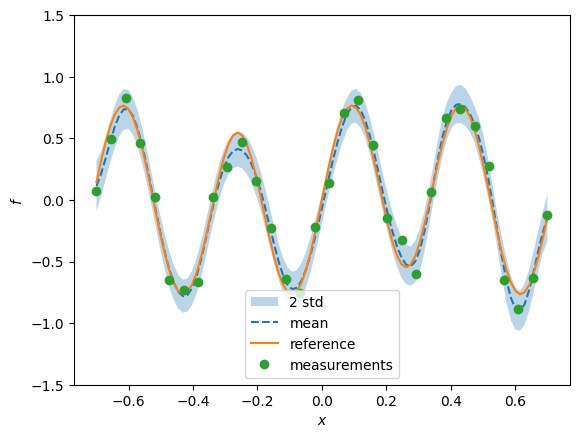

In [34]:
mu = np.mean(f_samples, axis=0)
std = np.std(f_samples, axis=0)
plt.fill_between(
    x_test.flatten(),
    (mu + 2 * std).flatten(),
    (mu - 2 * std).flatten(),
    alpha=0.3,
    label="2 std",
)
plt.plot(x_test, mu, "--", label="mean")
plt.plot(x_test, f_test, label="reference")
plt.plot(x_f_train, f_train, "o", label="measurements")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f$")
plt.ylim([-1.5, 1.5])
plt.show()

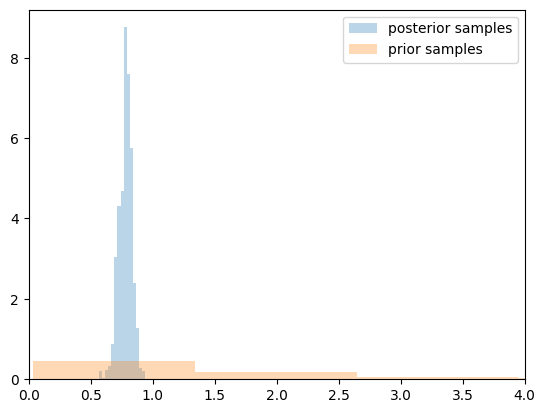

0.78133655 0.05320243


In [35]:
k_samples = np.exp(log_k_samples).flatten()
k_prior = tf.math.exp(process_log_k.prior.sample(sample_shape=[1000])).numpy().flatten()
plt.hist(k_samples, bins=15, density=True, alpha=0.3)
plt.xlim([0.0, 4])
plt.hist(k_prior, bins=15, density=True, alpha=0.3)
plt.legend(["posterior samples", "prior samples"])
plt.show()
print(np.mean(k_samples), np.std(k_samples))

# Few-shot function regression from data, using learned generators

$$y = A\sin(\omega x).$$

Suppose we have a stochastic surrogate model that approximates the family of the exact model:

$$\hat{y} = f(x;\xi).$$

#### Remark: 

if we know the exact form of the exact model, then we can directly infer its parameters and then obtain the inference of the model.

In [66]:
def load_data(noise_scale=0.05):
    # generate a few noisy observations for a sine wave, e.g. sin(10x)
    x = np.linspace(-0.7, -0.3, 3).reshape([-1, 1])
    u = 1.5 * np.sin(11 * x) + noise_scale * np.random.normal(size=x.shape)
    x_test = np.linspace(-1, 1, 100).reshape([-1, 1])
    u_test = 1.5 * np.sin(11 * x_test)

    return x, u, x_test, u_test


np.random.seed(123)
noise = 0.05
x_train, u_train, x_test, u_test = load_data(noise_scale=noise)

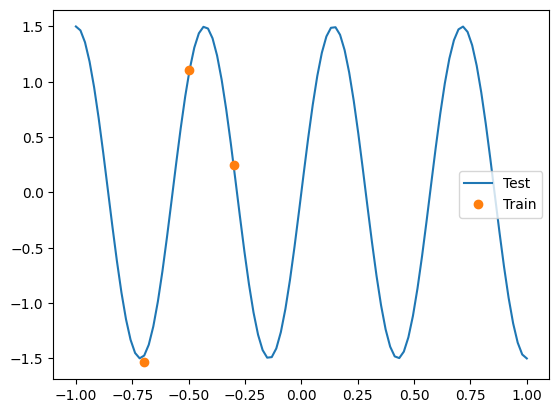

In [67]:
plt.plot(x_test, u_test, label="Test")
plt.plot(x_train, u_train, 'o', label="Train")
plt.legend()

#### Load the model

In [68]:
branch = neuq.utils.load_network(
    file_name="./NEURAL_UQ_PRETRAINED_MODEL/sine/branch.npy", activation=tf.tanh, resnet=True
)
trunk = neuq.utils.load_network(
    file_name="./NEURAL_UQ_PRETRAINED_MODEL/sine/trunk.npy", activation=tf.tanh, resnet=False
)

def make_surrogate(branchnet, trunknet):
    
    def _surrogate(inputs, var_list):
        xi = var_list[0]
        branch = branchnet(xi)
        trunk = trunknet(inputs)
        # return tf.matmul(branch, tf.transpose(trunk))
        return tf.matmul(trunk, tf.transpose(branch))
    
    return _surrogate

In [71]:
prior = neuq.variables.const.Samplable(mean=np.zeros([1, 10]), sigma=np.ones([1, 10]))
surrogate = make_surrogate(branch, trunk)
process_gan = neuq.process.Process(
    surrogate=surrogate, prior=prior,
)

likelihood_u = neuq.likelihoods.Normal(
    inputs=x_train,
    targets=u_train,
    processes=[process_gan],
    sigma=noise,
)

model = neuq.Model(
    processes=[process_gan], 
    likelihoods=[likelihood_u],
)

method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)
t0 = time.time()
samples, results = model.run()
print("Acceptance rate: %.3f \n" % (np.mean(results)))  # if HMC is used
print("Elapsed: ", time.time() - t0, " with backend {}".format(backend_name))

Supporting backend tensorflow

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.515 

Elapsed:  8.836228847503662  with backend <module 'neuraluq0.neuraluq.backend' from '/Users/raj/Dropbox (Brown)/NVIDIA-COURSE/ExxonMobil_Course_2024/JUPYTER_NOTEBOOKS/DAY_5/Lecture_13_Notebook/neuraluq0/neuraluq/backend.py'>


In [72]:
xi = samples[0][:, 0, :]
print(xi.shape)

u_samples = process_gan.surrogate(
    inputs=tf.constant(x_test, tf.float32),
    var_list=[tf.constant(xi, tf.float32)],
).numpy()
mu = np.mean(u_samples, axis=-1)
std = np.std(u_samples, axis=-1)

(1000, 10)


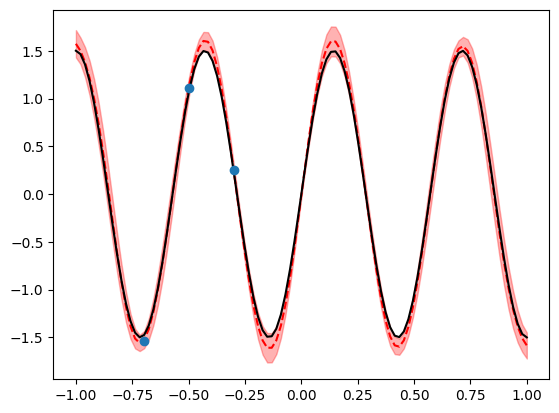

In [73]:
plt.plot(x_test, mu, "r--")
plt.fill_between(x_test.flatten(), (mu + 2*std).flatten(), (mu - 2*std).flatten(), color="r", alpha=0.3)
plt.plot(x_test, u_test, "k-")
plt.plot(x_train, u_train, 'o')

#### Priors

In [74]:
xi_posterior = samples[0][:, 0, :]
xi_prior = process_gan.prior.sample([1000])[0][:, 0, :]
print(xi_prior.shape, xi_posterior.shape)

u_prior_samples = process_gan.surrogate(
    inputs=tf.constant(x_test, tf.float32), 
    var_list=[tf.constant(xi_prior, tf.float32)],
).numpy()

(1000, 10) (1000, 10)


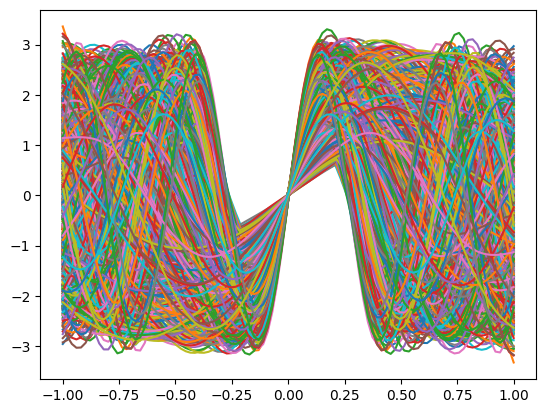

In [75]:
for i in range(1000):
    plt.plot(x_test.flatten(), u_prior_samples[:, i])

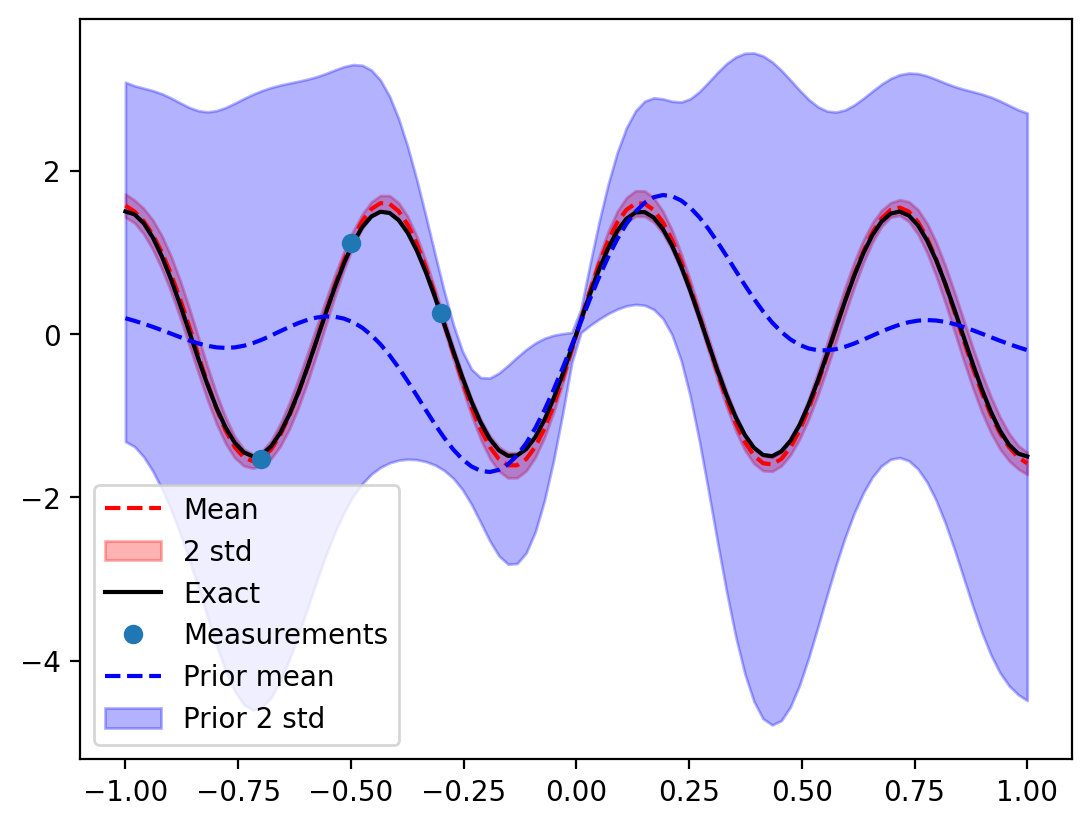

In [76]:
plt.figure(dpi=200)
plt.plot(x_test, mu, "r--")
plt.fill_between(x_test.flatten(), (mu + 2*std).flatten(), (mu - 2*std).flatten(), color="r", alpha=0.3)
plt.plot(x_test, u_test, "k-")
plt.plot(x_train, u_train, 'o')

mu_prior = np.mean(u_prior_samples, axis=-1)
std_prior = np.std(u_prior_samples, axis=-1)
plt.plot(x_test, mu_prior, "b--")
plt.fill_between(x_test.flatten(), (mu_prior + 2*std_prior).flatten(), (mu - 2*std_prior).flatten(), color="b", alpha=0.3)

plt.legend(["Mean", "2 std", "Exact", "Measurements", "Prior mean", "Prior 2 std"])
plt.show()